<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#Dataset-Information" data-toc-modified-id="Dataset-Information-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Dataset Information</a></span></li><li><span><a href="#Clean-Target-Variable" data-toc-modified-id="Clean-Target-Variable-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Clean Target Variable</a></span></li><li><span><a href="#Clean-Independent-Variables" data-toc-modified-id="Clean-Independent-Variables-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Clean Independent Variables</a></span></li><li><span><a href="#Feature-Visualizations" data-toc-modified-id="Feature-Visualizations-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Feature Visualizations</a></span></li></ul></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Feature Engineering</a></span></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Modeling</a></span><ul class="toc-item"><li><span><a href="#Determine-Best-Model" data-toc-modified-id="Determine-Best-Model-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Determine Best Model</a></span></li><li><span><a href="#Evaluating-Best-Model" data-toc-modified-id="Evaluating-Best-Model-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Evaluating Best Model</a></span></li></ul></li><li><span><a href="#External-Features" data-toc-modified-id="External-Features-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>External Features</a></span></li></ul></div>

# Introduction

- Load the houseprices data from Thinkful's database.
- Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.
- Now, split your data into train and test sets where 20% of the data resides in the test set.
- Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!
- Evaluate your best model on the test set.
- So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.


# Imports

In [3]:
from sqlalchemy import create_engine

from statsmodels.tsa.stattools import acf
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate


%matplotlib inline

# Options for pandas
pd.options.display.max_columns = 150
pd.options.display.max_rows = 150

In [4]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
housing_df = pd.read_sql_query('select * from houseprices', con=engine)

engine.dispose()

# EDA

## Dataset Information

In [5]:
housing_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000


In [6]:
categorical_features = 0
int_feature = 0
for col in housing_df.columns:
    if housing_df[col].dtype == 'O':
        categorical_features += 1
    else:
        int_feature += 1
print('Total columns:', len(housing_df.columns))
print('Numerical columns:', int_feature)
print('Categorical columns:', categorical_features)

Total columns: 81
Numerical columns: 38
Categorical columns: 43


## Clean Target Variable

Before exploring possible independent variable, it's important to clean the target variable beforehand. The reason is because cleaning the target variable may change the relationship between independent variables. 

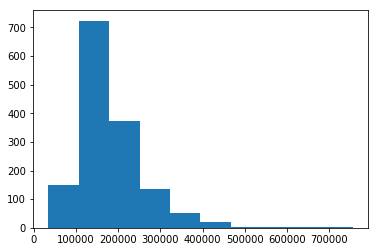

In [7]:
plt.hist(housing_df.saleprice)
plt.show()

The sale price distribution is postively skewed. There are a few outliers that could impact the modeling process. To prevent this we will eliminate observations with sale prices greater than $400,000

In [8]:
len(housing_df[housing_df['saleprice'] > 400000])
print('Drop {} rows with saleprice greater than $400,000'.format(
    len(housing_df[housing_df['saleprice'] > 400000])))
housing_df = housing_df[housing_df['saleprice'] < 400000]

Drop 28 rows with saleprice greater than $400,000


## Clean Independent Variables

In [9]:
# create dummy variables for categorical features
binary_count = 0
for col in housing_df.columns:
    # create dummy variables for binary features
    if (housing_df[col].dtype == 'O') and (len(housing_df[col].value_counts()) == 2):
        binary_col = housing_df[col].value_counts().keys()[0]
        housing_df["is_" +
                   binary_col] = pd.get_dummies(housing_df[col], drop_first=True)
        binary_count += 1
    # create dummy variables for other multi-category features
    elif (housing_df[col].dtype == 'O') and (len(housing_df[col].value_counts()) != 2):
        housing_df = pd.concat(
            [housing_df, pd.get_dummies(housing_df[col], prefix=col)], axis=1)
        binary_count += 1

In [10]:
categorical_count = 0
int_count = 0
for col in housing_df.columns:
    if housing_df[col].dtype == 'O':
        categorical_count += 1
    else:
        int_count += 1
print('Total columns:', len(housing_df.columns))
print('Numerical columns:', int_count - binary_count)
print('Binary columns:', binary_count)
print('Categorical columns:', categorical_count)

Total columns: 329
Numerical columns: 243
Binary columns: 43
Categorical columns: 43


## Feature Visualizations

According to [](), the most important factors for house prices are:

- Supply and demand
- Location
- Square Feet
- Number of bedrooms/bathrooms
- House quality interior/exterior
- Parking

Lets explore each of these variables' relationship with sale price.

/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(obj)


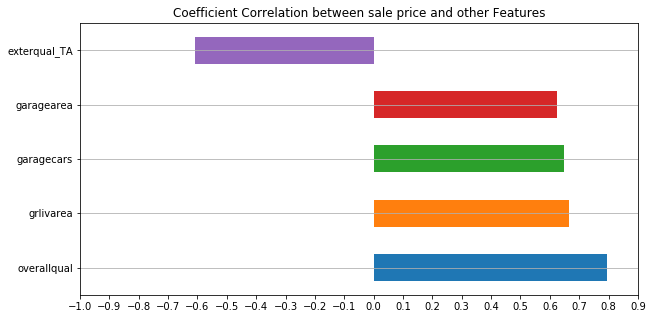

In [11]:
# plot features with coefficient correlations stronger than .5 in regards to sale price.
corr = housing_df.corr()
plot_corr = corr[(corr.saleprice > .6) | (corr.saleprice < -.6)]
plot_corr = plot_corr.saleprice
plot_corr.drop('saleprice', inplace=True)

plt.figure(figsize=(10, 5))
plot_corr.plot(kind='barh', grid=True)
plt.grid(axis='x')
plt.title('Coefficient Correlation between sale price and other Features')
plt.xticks(np.arange(-1, 1, .1))
plt.show()

The overallqual variable had the strongest correlation with sale price. # explain what overallqual means in dataset. In addition, exterqual_TA had a somewhat strong correlation with sale price. These two variables relates to the house quality interior/exterior factor mentioned above in the real estate list. 

The grlivarea also had a strong correlation. The variable is the ... This falls under the square feet category according to the real estate list. 

We can assume that garagearea and garagecars relate to the parking factor in the list. Since these two variables are proportional to one another, we can disregard one of them from the feature list.  

Surprisingly location and number of bedrooms/bathrooms were not strongly correlated with sale price. The bedrooms/bathrooms variables will be kept since there may be a transformation that could spark a correlation with sale price. 

# Feature Engineering

In [205]:
# combine related variables within feature list

housing_df['total_sf'] = housing_df.totalbsmtsf + housing_df.grlivarea + housing_df.garagearea 
+ housing_df.wooddecksf + housing_df.openporchsf + housing_df.poolarea

housing_df['total_fullbaths'] = housing_df.bsmtfullbath + housing_df.fullbath
housing_df['total_halfbaths'] = housing_df.bsmthalfbath + housing_df.halfbath

In [206]:
feature_list = ['overallqual', 'total_sf',
                'total_fullbaths', 'total_halfbaths']

housing_df[feature_list].head()

,overallqual,total_sf,total_fullbaths,total_halfbaths
0,7,3114,3,1
1,6,2984,2,1
2,7,3314,3,1
3,7,3115,2,0
4,8,4179,3,1


In [204]:
# null count in features list
null_count = corr.isnull().sum()
null_count[null_count > 0]

lotfrontage            8
garageyrblt            2
is_AllPub              1
condition2_RRAe        1
condition2_RRAn        1
roofstyle_Shed         1
roofmatl_Metal         1
exterior1st_AsphShn    1
extercond_Po           1
heating_Floor          1
functional_Sev         1
miscfeature_Gar2       1
dtype: int64

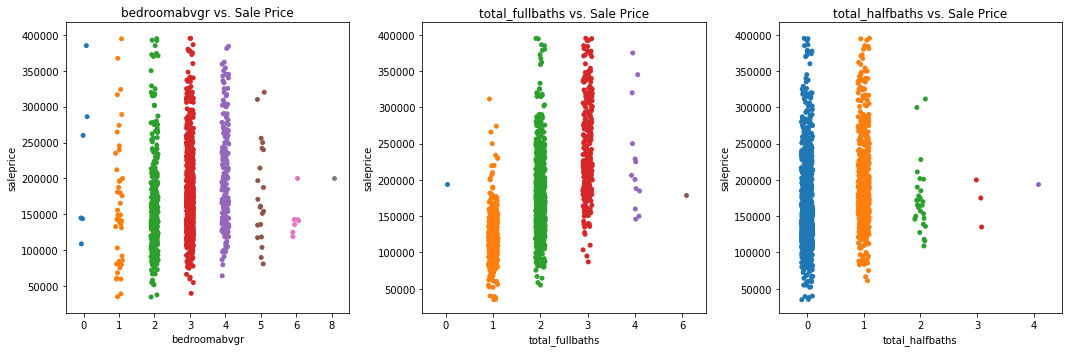

In [15]:
def categorical_plot(df, columns, n_cols=2):
    plt.figure(figsize=(15, 5))
    n_rows = len(columns) / n_cols
    for i in range(1, len(columns)+1):
        plt.subplot(n_rows, n_cols, i)
        sns.stripplot(housing_df[columns[i-1]],
                      housing_df.saleprice, jitter=True)
        plt.title('{} vs. Sale Price'.format(columns[i-1]))
    plt.tight_layout()


plot_col = ['bedroomabvgr', 'total_fullbaths', 'total_halfbaths']
categorical_plot(housing_df, plot_col, 3)

# Modeling

## Determine Best Model

In [185]:
feature_list = ['overallqual', 'total_sf',
                'total_fullbaths', 'total_halfbaths']

train_x, test_x, train_y, test_y = train_test_split(
    housing_df[feature_list], housing_df['saleprice'], test_size=.2)

elastic = ElasticNet(alpha=10**25)
ridge = Ridge(alpha=10**25)
lasso = Lasso(alpha=10*25)
model_list = {'elastic': elastic, 'ridge': ridge, 'lasso': lasso}

In [3]:
def model_results(model_list, data, target):
    scoring = ['fit_time', 'score_time', 'test_r2', 'train_r2', 'test_neg_mean_absolute_error',
               'train_neg_mean_absolute_error', 'test_neg_mean_squared_error', 'train_neg_mean_squared_error']
    results_df = pd.DataFrame(columns=[score for score in scoring], index=[
                              name for name in model_list])
    for name, model in model_list.items():
        model_results = cross_validate(model, data, target, cv=5, scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error'],
                                       return_train_score=True)
        scoring = list(model_results.keys())
        # convert error to positive and generate RMSE
        for score in scoring:
            if (score == 'test_neg_mean_squared_error') or (score == 'train_neg_mean_squared_error'):
                #model_results['root_'+score[:5]+score[9:]] = np.sqrt(model_results[score] * -1)
                model_results['root_'+score[:5]+score[9:]
                              ] = np.sqrt(model_results[score] * -1).mean()
                del model_results[score]
            elif (score == 'test_neg_mean_absolute_error') or (score == 'train_neg_mean_absolute_error'):
                model_results[score[:5]+score[9:]
                              ] = (model_results[score] * -1).mean()
                del model_results[score]
            else:
                #model_results[score[:5]+score[9:]] = model_results[score] * -1
                model_results[score] = model_results[score].mean()
        model_df = pd.DataFrame(model_results, index=[name])

    return model_df

Figure out how to add model_df to result_df

In [2]:
model_results(model_list, train_x, train_y)

NameError: name 'model_list' is not defined

## Evaluating Best Model

In [235]:
housing_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,...,heatingqc_Po,heatingqc_TA,is_Y,electrical_FuseA,electrical_FuseF,electrical_FuseP,electrical_Mix,electrical_SBrkr,kitchenqual_Ex,kitchenqual_Fa,kitchenqual_Gd,kitchenqual_TA,functional_Maj1,functional_Maj2,functional_Min1,functional_Min2,functional_Mod,functional_Sev,functional_Typ,fireplacequ_Ex,fireplacequ_Fa,fireplacequ_Gd,fireplacequ_Po,fireplacequ_TA,garagetype_2Types,garagetype_Attchd,garagetype_Basment,garagetype_BuiltIn,garagetype_CarPort,garagetype_Detchd,garagefinish_Fin,garagefinish_RFn,garagefinish_Unf,garagequal_Ex,garagequal_Fa,garagequal_Gd,garagequal_Po,garagequal_TA,garagecond_Ex,garagecond_Fa,garagecond_Gd,garagecond_Po,garagecond_TA,paveddrive_N,paveddrive_P,paveddrive_Y,poolqc_Ex,poolqc_Fa,poolqc_Gd,fence_GdPrv,fence_GdWo,fence_MnPrv,fence_MnWw,miscfeature_Gar2,miscfeature_Othr,miscfeature_Shed,miscfeature_TenC,saletype_COD,saletype_CWD,saletype_Con,saletype_ConLD,saletype_ConLI,saletype_ConLw,saletype_New,saletype_Oth,saletype_WD,salecondition_Abnorml,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,salecondition_Normal,salecondition_Partial,total_sf,total_fullbaths,total_halfbaths
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,...,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,3114,3,1
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,...,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,2984,2,1
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,...,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,3314,3,1
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,...,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,3115,2,0
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053

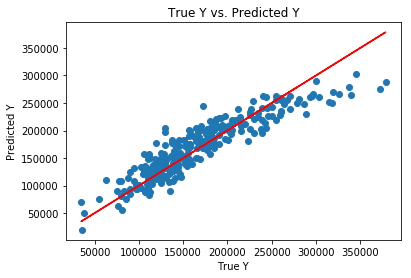

R2:  0.7497352787996546
RMSE: 25024.004574446524
MAE: 19162.07575640416
MAPE: 12.643642912175283


In [233]:
lasso.fit(train_x, train_y)
pred_y = lasso.predict(test_x)

plt.scatter(test_y, pred_y)
plt.plot(test_y, test_y, color='red')
plt.title('True Y vs. Predicted Y')
plt.xlabel('True Y')
plt.ylabel('Predicted Y')
plt.show()

print('R2: ', lasso.score(train_x, train_y))
print('RMSE:', rmse(test_y, pred_y))
print('MAE:', mean_absolute_error(test_y, pred_y))
print('MAPE:', (np.abs(test_y - pred_y) / test_y).mean() *100)

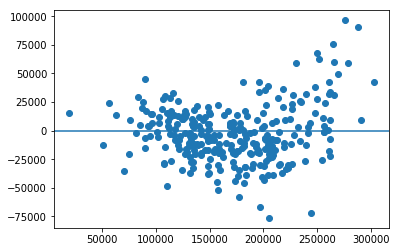

In [215]:
error_term = test_y - pred_y
plt.scatter(pred_y, error_term)
plt.axhline(y=0)


# External Features

<BarContainer object of 1432 artists>

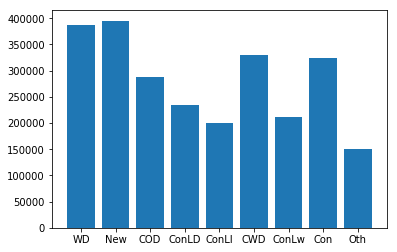

In [209]:
plt.bar(housing_df.saletype, housing_df.saleprice)